In [2]:
import os
from os import path
import shutil
import time
import copy
import numpy as np
import pandas as pd

#Import PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models

#Import Matplotlib
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

# Data Loading and Preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.makedirs("dataset/")

##### Unzip

In [ ]:
!unzip /content/drive/MyDrive/Learn_Pytorch/workshop/NUMTA.zip -d /content/dataset/NUMTA

In [5]:
# Hyperparameters
# shopne pawa value
batch_size = 256
num_iters = 3200
input_shape = 28*28 # num_features = 784
output_shape = 10
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
PATH = 'dataset/NUMTA/'
TRAIN_PATH = 'dataset/NUMTA/training-a/'
TEST_PATH = 'dataset/NUMTA/testing-all-corrected/testing-a/'
os.listdir(PATH)

['testing-b',
 'training-b',
 'testing-d',
 'training-b.csv',
 'training-c',
 'training-e',
 'testing-auga',
 'testing-c',
 'training-d.csv',
 'testing-a',
 'training-c.csv',
 'training-d',
 'training-a',
 'testing-augc',
 'training-e.csv',
 'training-a.csv',
 'testing-all-corrected',
 'testing-f',
 'testing-e']

In [8]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L') # 'L' mode image means it is a single channel image
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [9]:
df = pd.read_csv(PATH + "training-a.csv")[['filename', 'digit']]
df.head()

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0


In [10]:
mean = [0.5,]
std = [0.5, ]

transform = test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

In [11]:
dataset = Dataset(df, TRAIN_PATH, transform)

In [12]:
len(dataset)

19702

## Data Splitting

Training Set, Validation Set, Testing Set

In [13]:
# split data 20% for validation
val_size = 0.2

# obtain training indices that will be used for validation
dataset_size = len(dataset)

# mix data
# indices of all data
indices = list(range(dataset_size))

# random the index
np.random.shuffle(indices)

split = int(np.floor(val_size * dataset_size))

# divied into two part
train_idx, val_idx = indices[split:], indices[:split]

In [14]:
print("Train Samples: ",len(train_idx))
print("Validation Samples: ",len(val_idx))

Train Samples:  15762
Validation Samples:  3940


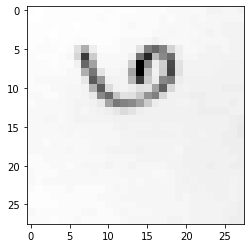

In [15]:
show_img = dataset[1][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')

In [16]:
dataset[1][1] #label

3

In [17]:
# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

## Dataloader
Dataloader keeps data manageable and helps to simplify your machine learning pipeline. a Dataset stores all data, and Dataloader is can be used to **iterate** through the data, **manage batches**, **transform** the data, and much more.

In [18]:
'''
MAKING DATASET ITERABLE
'''

# prepare loaders
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)


#Note:
#since we already randomly shuffle the index of our sampler. That's why we don't need to pass shuffle=True again here.
#otherwise, we need to pass shuffle=True also.
#sothat, in each epoch data will be shuffled


In [19]:
image, label = next(iter(val_loader))
image.shape, label.shape

# [batch size, number of channel, size, size ]

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

# FCN Model

In [20]:
class FC(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)    #Input Layer
        self.fc2 = nn.Linear(512, 256)          #Hidden Layer
        self.fc3 = nn.Linear(256, 128)          #Hidden Layer
        self.fc4 = nn.Linear(128, num_classes)   #Output Layer

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        # probas = F.log_softmax(self.fc4(x), dim=1)
        logits = self.fc4(x)  #logits are output without activation function like softmax/sigmoid
        
        return logits

In [21]:
'''
INSTANTIATE MODEL CLASS
'''

model = FC(input_size=input_shape, num_classes=output_shape)

# To enable GPU
model.to(device)

FC(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

## Optimizer and Loss Function

In [22]:
# INSTANTIATE OPTIMIZER CLASS
optimizer1 = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion1 = nn.CrossEntropyLoss()

## Batch Size, Epochs, Iterations

In [23]:
num_batches = (len(train_idx) / batch_size)
num_epochs = num_iters / num_batches
num_epochs = int(num_epochs)

print(f'Total Epochs: {num_epochs}')

Total Epochs: 51


In [26]:
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_idx), 'val': len(val_idx)}

# ConvNets

In [33]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # input_shape = 1X28X28
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        self.conv1 = nn.Conv2d(1, 10, 5) #output: 10X24X24
        #torch.nn.MaxPool2d(kernel_size, stride=None)
        self.pool1 = nn.MaxPool2d(2, 2) #output: 10X12X12
        self.conv2 = nn.Conv2d(10, 20, 5) #output: 20X8X8
        self.pool2 = nn.MaxPool2d(2, 2) #output: 20X4X4
        self.fc1 = nn.Linear(20 * 4 * 4, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [34]:
'''
INSTANTIATE MODEL CLASS
'''

model2 = ConvNet(num_classes=output_shape)

# To enable GPU
model2.to(device)

ConvNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)

In [35]:
# INSTANTIATE OPTIMIZER CLASS
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)
criterion2 = nn.CrossEntropyLoss()

In [36]:
#@title Default title text
num_batches = (len(train_idx) / batch_size)
num_epochs = num_iters / num_batches
num_epochs = int(num_epochs)

print(f'Total Epochs: {num_epochs}')

Total Epochs: 51


In [37]:
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_idx), 'val': len(val_idx)}

# Training

In [27]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    all_train_loss = []
    all_val_loss = []
    all_train_acc = []
    all_val_acc = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(0, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        
                        loss.backward() #calculate gradients
                        optimizer.step() # weights_update 
                        optimizer.zero_grad() #prevents of accumulation gradients

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              all_train_loss.append(epoch_loss)
              all_train_acc.append(epoch_acc.item())
            elif phase == 'val':
              all_val_loss.append(epoch_loss)
              all_val_acc.append(epoch_acc.item())              

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # plotting the training and validation loss
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(all_train_loss, label='Training loss')
    axs[0].plot(all_val_loss, label='Validation loss')
    axs[0].set_label("Training VS. Validation Loss")
    axs[0].set(xlabel="Epochs", ylabel="Loss")
    # plotting the training and validation accuracy
    axs[1].plot(all_train_acc, label='Training accuracyc')
    axs[1].plot(all_val_acc, label='Validation accuracy')
    axs[1].set_label("Training VS. Validation Accuracy")
    axs[1].set(xlabel="Epochs", ylabel="Accuracy")

    axs[0].legend()
    axs[1].legend()

    # fig.tight_layout()
    plt.show()    
    return model

### Training FCN

Epoch 0/24
----------
train Loss: 2.3012 Acc: 0.1093
val Loss: 2.2970 Acc: 0.0982

Epoch 1/24
----------
train Loss: 2.2374 Acc: 0.1667
val Loss: 2.2152 Acc: 0.1574

Epoch 2/24
----------
train Loss: 2.0648 Acc: 0.2659
val Loss: 2.0701 Acc: 0.2135

Epoch 3/24
----------
train Loss: 1.8744 Acc: 0.3361
val Loss: 1.7759 Acc: 0.3566

Epoch 4/24
----------
train Loss: 1.6846 Acc: 0.4105
val Loss: 1.6383 Acc: 0.4368

Epoch 5/24
----------
train Loss: 1.5789 Acc: 0.4413
val Loss: 1.5153 Acc: 0.4802

Epoch 6/24
----------
train Loss: 1.4831 Acc: 0.4786
val Loss: 1.5466 Acc: 0.4543

Epoch 7/24
----------
train Loss: 1.5244 Acc: 0.4542
val Loss: 1.3888 Acc: 0.5320

Epoch 8/24
----------
train Loss: 1.4105 Acc: 0.4973
val Loss: 1.3526 Acc: 0.5315

Epoch 9/24
----------
train Loss: 1.3309 Acc: 0.5373
val Loss: 1.3254 Acc: 0.5391

Epoch 10/24
----------
train Loss: 1.2867 Acc: 0.5582
val Loss: 1.3343 Acc: 0.5317

Epoch 11/24
----------
train Loss: 1.3097 Acc: 0.5422
val Loss: 1.1790 Acc: 0.6104

Ep

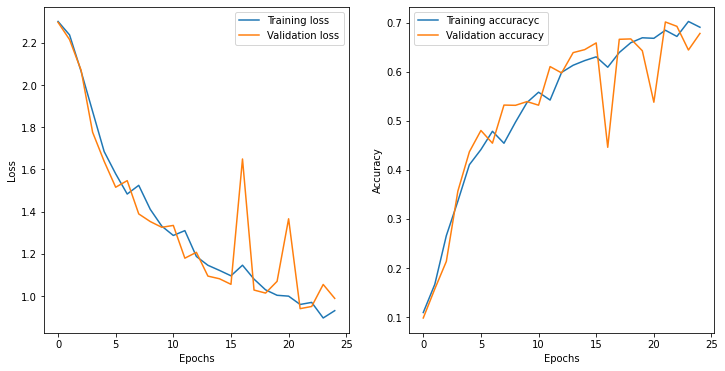

In [29]:
model = train_model(model, criterion1 , optimizer1, num_epochs=25)

### Training ConvNet

In [39]:
torch.save(model.state_dict(), "drive/MyDrive/Learn_Pytorch/workshop/fc.pth")

torch.save(model2.state_dict(), "drive/MyDrive/Learn_Pytorch/workshop/conv.pth")

In [40]:
ls

dataset/  drive/  sample_data/


Epoch 0/24
----------
train Loss: 2.2382 Acc: 0.1676
val Loss: 1.9887 Acc: 0.2817

Epoch 1/24
----------
train Loss: 1.7449 Acc: 0.3637
val Loss: 1.5141 Acc: 0.4327

Epoch 2/24
----------
train Loss: 1.4238 Acc: 0.4758
val Loss: 1.2935 Acc: 0.5310

Epoch 3/24
----------
train Loss: 1.2606 Acc: 0.5389
val Loss: 1.1962 Acc: 0.5571

Epoch 4/24
----------
train Loss: 1.2068 Acc: 0.5691
val Loss: 1.0535 Acc: 0.6327

Epoch 5/24
----------
train Loss: 1.0409 Acc: 0.6362
val Loss: 0.9535 Acc: 0.6777

Epoch 6/24
----------
train Loss: 0.9361 Acc: 0.6743
val Loss: 0.8758 Acc: 0.7030

Epoch 7/24
----------
train Loss: 0.8603 Acc: 0.6972
val Loss: 0.8539 Acc: 0.7030

Epoch 8/24
----------
train Loss: 0.8058 Acc: 0.7229
val Loss: 0.7958 Acc: 0.7249

Epoch 9/24
----------
train Loss: 0.7449 Acc: 0.7439
val Loss: 0.6816 Acc: 0.7759

Epoch 10/24
----------
train Loss: 0.6790 Acc: 0.7696
val Loss: 0.6307 Acc: 0.7896

Epoch 11/24
----------
train Loss: 0.6340 Acc: 0.7856
val Loss: 0.7911 Acc: 0.7228

Ep

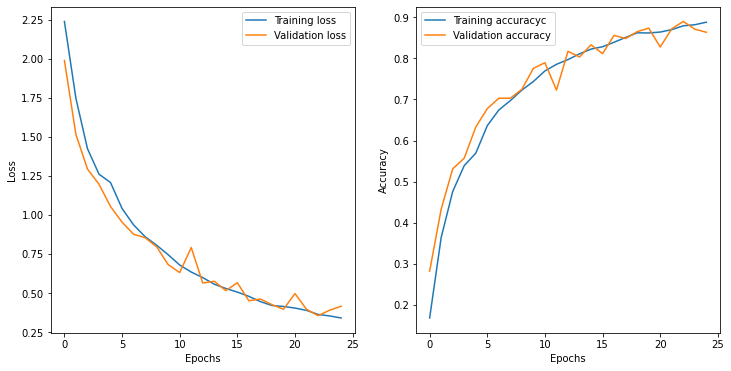

In [42]:
model2 = train_model(model2, criterion2, optimizer2, num_epochs=25)

## Evaluating Classwise Performance

In [31]:
classes = np.arange(0,10)
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### FCN

In [32]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 70.1269035532995 %
Accuracy of 0: 68.02030456852792 %
Accuracy of 1: 64.73551637279597 %
Accuracy of 2: 84.69135802469135 %
Accuracy of 3: 79.01234567901234 %
Accuracy of 4: 90.02375296912113 %
Accuracy of 5: 63.63636363636363 %
Accuracy of 6: 93.2975871313673 %
Accuracy of 7: 65.60846560846561 %
Accuracy of 8: 63.44647519582245 %
Accuracy of 9: 27.061855670103093 %


## ConvNet

In [43]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 89.01015228426395 %
Accuracy of 0: 86.5482233502538 %
Accuracy of 1: 79.84886649874055 %
Accuracy of 2: 91.60493827160494 %
Accuracy of 3: 90.8641975308642 %
Accuracy of 4: 96.67458432304038 %
Accuracy of 5: 93.93939393939394 %
Accuracy of 6: 92.22520107238606 %
Accuracy of 7: 95.23809523809524 %
Accuracy of 8: 91.38381201044386 %
Accuracy of 9: 71.3917525773196 %
